# Lung Cancer Classification using Transfer Learning
This notebook walks through:
- Loading data with automatic validation split
- Building a model with EfficientNet backbone
- Training and fine-tuning
- Saving the trained model
- Sample prediction


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import os



## Setup dataset directory and parameters

In [11]:
dataset_dir = 'dataset'  # your dataset folder
batch_size = 32
img_size = (224, 224)

## Load training and validation dataset with 20% validation split

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 1097 files belonging to 3 classes.
Using 878 files for training.
Found 1097 files belonging to 3 classes.
Using 219 files for validation.


## Preprocess images with EfficientNet preprocessing

In [13]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

## Optimize data pipeline for performance

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## Build model with EfficientNetB0 base (frozen initially)

In [15]:
base_model = EfficientNetB0(include_top=False, input_shape=img_size+(3,), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # Your classes: ['Benign', 'Malignant', 'Normal']
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,706,982 (17.96 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Train the top layers

In [16]:
initial_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)

Epoch 1/10


28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 718ms/step - accuracy: 0.7170 - loss: 0.6859 - val_accuracy: 0.8630 - val_loss: 0.3606
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 538ms/step - accuracy: 0.8877 - loss: 0.3075 - val_accuracy: 0.8767 - val_loss: 0.3090
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 518ms/step - accuracy: 0.8997 - loss: 0.2329 - val_accuracy: 0.8721 - val_loss: 0.3013
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step - accuracy: 0.9155 - loss: 0.2039 - val_accuracy: 0.8995 - val_loss: 0.2531
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - accuracy: 0.9153 - loss: 0.1996 - val_accuracy: 0.9041 - val_loss: 0.2267
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 538ms/step - accuracy: 0.9258 - loss: 0.1790 - val_accuracy: 0.9041 - val_loss: 0.2280
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 557ms/step - accuracy: 0.9205 - loss: 0.1971 - val_accuracy: 0.8904 - val_loss: 0.2875
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 533ms/step - accuracy: 0.9271 - loss: 0.1673 - val_accuracy: 0.899

## Unfreeze some layers for fine-tuning

In [17]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, 
                         validation_data=val_ds, 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1])

Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7358 - loss: 0.8572 - val_accuracy: 0.9178 - val_loss: 0.2050
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8476 - loss: 0.3914 - val_accuracy: 0.9224 - val_loss: 0.2269
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 905ms/step - accuracy: 0.8797 - loss: 0.2990 - val_accuracy: 0.8950 - val_loss: 0.2496
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 844ms/step - accuracy: 0.8816 - loss: 0.2880 - val_accuracy: 0.8904 - val_loss: 0.2682
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8997 - loss: 0.2739 - val_accuracy: 0.8904 - val_loss: 0.2768
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 897ms/step - accuracy: 0.9191 - loss: 0.2275 - val_accuracy: 0.8904 - val_loss: 0.2864
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9092 - loss: 0.2112 - val_accuracy: 0.8767 - val_loss: 0.2924
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 844ms/step - accuracy: 0.9162 - loss: 0.1937 - val_accuracy

## Save your trained model

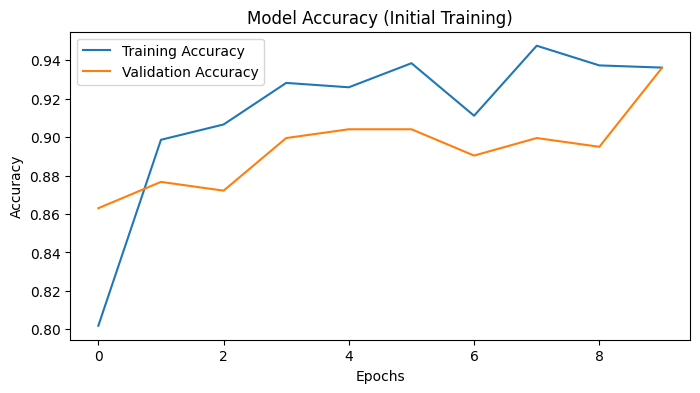

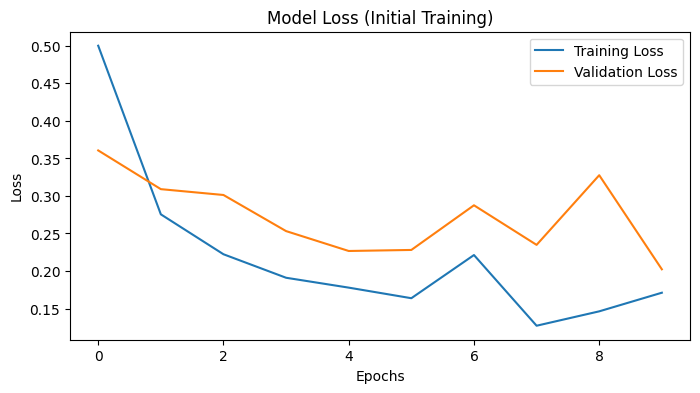

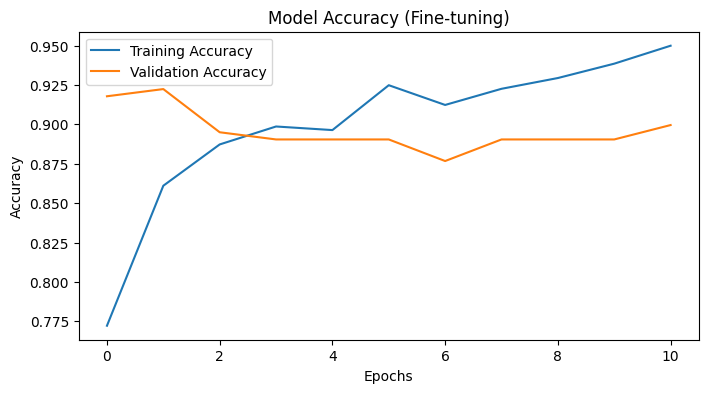

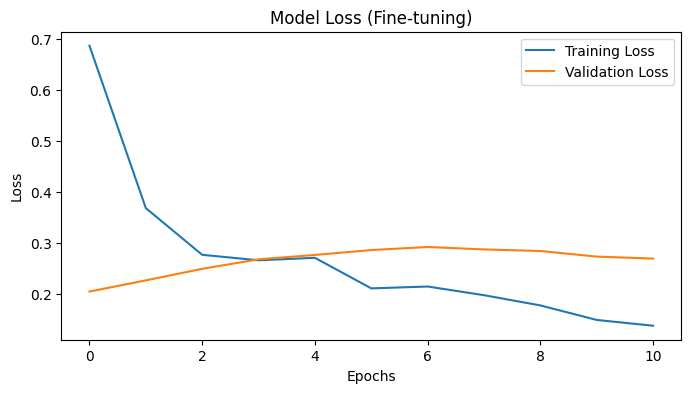

In [19]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, title_suffix=''):
    # Plot accuracy only
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy {title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss only
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss {title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage after training:
plot_accuracy_and_loss(history, title_suffix='(Initial Training)')
plot_accuracy_and_loss(history_fine, title_suffix='(Fine-tuning)')



In [20]:
model.save('lung_cancer_model.h5')
print('Training done and model saved as lung_cancer_model.h5')

Training done and model saved as lung_cancer_model.h5


## Quick test prediction on a single image
Replace `'your_image.jpg'` with a path to your lung CT scan image.

In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def prepare_image_for_pred(path):
    img = load_img(path, target_size=img_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

test_image_path = r'C:\Users\merau\Desktop\lung_cancer_project\dataset\Malignant\Malignant case (16).jpg'
img_for_pred = prepare_image_for_pred(test_image_path)

pred = model.predict(img_for_pred)
pred_class = np.argmax(pred[0])
class_names = ['Benign', 'Malignant', 'Normal']
print(f"Prediction: {class_names[pred_class]} with confidence {pred[0][pred_class]*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Malignant with confidence 100.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 865ms/step


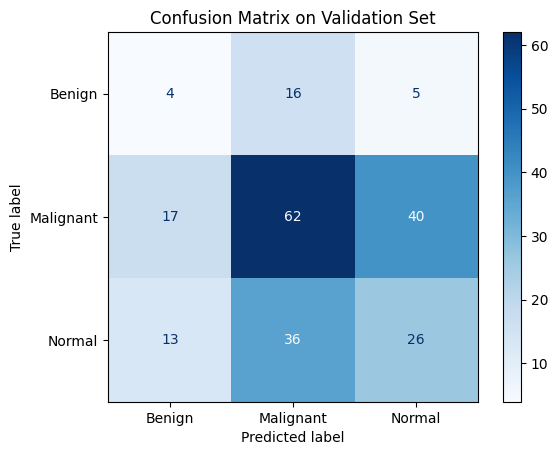

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare true labels and predicted labels for the validation data
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Define your class names exactly in the order your model uses
class_names = ['Benign', 'Malignant', 'Normal']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create and plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Set')
plt.show()
